In [ ]:
# default_exp io

In [ ]:
# export
from fastscript import call_parse, Param, bool_arg
from scipy import ndimage

import h5py
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pydicom
import scipy.io as spio

# I2T2.io

> I2T2.io loads and saves common file formats used in medical imaging.

In [ ]:
# test
try:
    import gdcm
    print('Successfully imported GDCM')
except ImportError:
    print('Could not import GDCM')

Successfully imported GDCM


## Loading dicom data

In [ ]:
#export
def _get_dcm_paths_from_folderpath(path_to_dicom_dir, dicom_extension='DCM'):
    """
    Returns a list of paths to dicom files within a directory.
    Attributes:
        path_to_dicom_dir (str): path to folder containing dicoms.
        dicom_extension (str): case insensitive str with dicom extension.
    Returns:
        dcm_paths_list (list): list of paths to dicom files.
    """
    if not path_to_dicom_dir.endswith(('/')):
        path_to_dicom_dir = f"{path_to_dicom_dir}/"

    filenames_list = os.listdir(path_to_dicom_dir)

    dcm_paths_list = [os.path.join(path_to_dicom_dir, name) for name in filenames_list if str.lower(dicom_extension) in str.lower(name)]

    return(dcm_paths_list)

In [ ]:
#export
def _read_dicom_from_file(dicom_file_path):
    """
    Reads dicom using pydicom.dcmread.
    Attributes:
        dicom_file_path (str): path to file of interest
    Returns:
        dcm (FileDataset): result from pydicom.dcmread()
    """
    try:
        return(pydicom.dcmread(dicom_file_path))
    except Exception as error:
        print(error)

In [ ]:
#export
def _get_tag_from_loaded_dicom(dcm, tag):
    """
    Get tag from loaded pydicom data structure.
    Attributes:
        dcm (FileDataset): dicom slice, result from pydicom.dcmread()
        tag (str): key of interest in the dicom (e.g. "SOPClassUID")
    Returns:
        content (str): the contant of the dicom key
    """
    try:
        content = dcm[tag].value
        return(content)
    except Exception as e:
        print(str(tag), " tag was not found! Skipping...", e)
        return None

In [ ]:
#export
def _get_normal_from_dicom_slice(dcm):
    """
    Get normal vector from a dicom slice.
    Attributes:
        dcm (FileDataset): dicom slice, result from pydicom.dcmread()
    Returns:
        normal_vector (arr): numpy array with dimensions of slice's normal vector
    """

    cosines = _get_tag_from_loaded_dicom(dcm,'ImageOrientationPatient')
    cosines = [float(i) for i in cosines]

    normal = np.empty(3)
    normal[0] = cosines[1]*cosines[5] - cosines[2]*cosines[4];
    normal[1] = cosines[2]*cosines[3] - cosines[0]*cosines[5];
    normal[2] = cosines[0]*cosines[4] - cosines[1]*cosines[3];
    return(np.array(normal))

In [ ]:
#export
def _get_dicom_slice_IPP_along_normal(dcm):
    """
    Get dicom slice ImagePositionPatient (IPP) in the direction of the slice's normal vector
    Attributes:
        dcm (FileDataset): dicom slice, result from pydicom.dcmread()
    Returns:
        slice_ipp (double): ImagePositionPatient value along slice's normal vector
    """

    IPP = _get_tag_from_loaded_dicom(dcm, 'ImagePositionPatient')
    IPP = [float(i) for i in IPP]
    slice_ipp = np.inner(_get_normal_from_dicom_slice(dcm), IPP)

    return(slice_ipp)

In [ ]:
#export
def _get_distance_between_two_dicom_slices(dcm1, dcm2):
    """
    Get distance between two dicom slices along the normal vector
    Attributes:
        dcm1 (FileDataset): dicom slice, result from pydicom.dcmread()
        dcm2 (FileDataset): dicom slice, result from pydicom.dcmread()
    Returns:
        distance_vector (arr): numpy array with difference between center of two slices
    """

    slice_position_1 = _get_dicom_slice_IPP_along_normal(dcm1)

    slice_position_2 = _get_dicom_slice_IPP_along_normal(dcm2)

    distance = np.abs(slice_position_2 - slice_position_1)

    return(distance)

In [ ]:
#export
class dicom_dataframe:
    """
    Class for sorting, selecting and loading portions of dicom data.

    Objects of this class are pandas dataframes with at least one main column ('DS')
    that holds the results of pydicom.read() for each file read during initialization.
    Users can populate the dataframe with new columns using DICOM tags to facilitate
    subsequent filtering, sorting and data loading.
    """

    def __init__(self, path_to_dicom_dir, dicom_extension='dcm', read_single_random_dcm=False):
        """
        Read dicom files from folder and add them to a pandas dataframe.
        Attributes:
            path_to_dicom_dir (str): path to directory containing dicom files
            dicom_extension (str): cases insensitive string with dicom file extension
            read_single_random_dcm (bool): whether or not to return a single, random dicom file
        Returns:
            updates self.dataframe with new columns.
        """
        if not path_to_dicom_dir.endswith(('/')):
            path_to_dicom_dir = f"{path_to_dicom_dir}/"

        df = pd.DataFrame()
        list_of_paths = _get_dcm_paths_from_folderpath(path_to_dicom_dir, dicom_extension)

        if not list_of_paths:
            warnings.warn('No dicom found. Incorrect dicom extension?')
            self.is_empty = True
            return(None)

        if read_single_random_dcm:
            import random
            if list_of_paths:
                list_of_paths = random.sample(list_of_paths, 1)

        df['pathname'] = list_of_paths

        #to get the filenames just remove the path from it
        df['filename'] = df['pathname'].str.replace(path_to_dicom_dir, '')

        dicom_df = pd.DataFrame(columns=['DS'])
        dicom_df['DS'] = df['pathname'].apply(_read_dicom_from_file)

        self.dataframe = dicom_df
        self.is_empty = False
        self.populate_dataframe(['SeriesInstanceUID',
                                'ImagePositionPatient'])

    def populate_dataframe(self, tags_list):
        """
        Populate pandas dataframe with columns of interest.
        Attributes:
            tags_list (list): list of DICOM tags of interest (e.g. ['SOPClassUID','SeriesInstanceUID'])
        Returns:
            updates self.dataframe with new columns.
        """
        for tag in tags_list:
            try:
                self.dataframe[tag] = self.dataframe['DS'].apply(lambda x: _get_tag_from_loaded_dicom(x, tag))
            except Exception as error:
                print('Tag not found! Error: ', error)

    def filter_dataframe_by_column_value(self, column, value):
        """
        Filter pandas dataframe based on value of existing column.
        Attributes:
            column (str): column of interest (e.g. 'SOPClassUID')
            value (str): value used for dataframe subset selection
        Returns:
            updates self.dataframe to only hold request subset of data.
        """
        try:
            df_column = self.dataframe[column]
        except Exception as error:
            print('Could not find column in dataframe. Error: ', error)

        self.dataframe = self.dataframe[df_column == value]

    def sort_dataframe_by_IPP_normal(self):
        """
        Sort dicoms dataframe by ImagePositionPatient value in the direction of the slice normal
        """
        self.dataframe['ImagePositionPatient_normal'] = self.dataframe['DS'].apply(lambda x: _get_dicom_slice_IPP_along_normal(x))
        self.dataframe = self.dataframe.sort_values('ImagePositionPatient_normal')
        self.dataframe.reset_index(drop=True)

    def get_pixel_data(self):
        """
        Get pixel data from dataframe.
        Returns:
            pixel_array (arr) numpy array containing pixel data
        """

        self.dataframe['PixelArray'] = [x.pixel_array for x in self.dataframe['DS']]

        num_slices = len(self.dataframe)
        if  num_slices > 1:
            if 'SeriesInstanceUID' not in self.dataframe.columns:
                print('Warning: SeriesInstanceUID not found in dataset. Unable to check if dicom is single series.')
            elif len(self.dataframe['SeriesInstanceUID'].unique()) > 1:
                print('Warning: Multiple series found in dataframe. You might want to first select a single series with `select_by_column_and_values`.')

            self.sort_dataframe_by_IPP_normal()

        pixel_array = np.dstack(np.asarray(self.dataframe.PixelArray))

        return(pixel_array)

### Usage

`dicom_dataframe` takes a path to a folder containing the dicom files of interest.

It then constructs a pandas dataframe whose first column (DS) is the result of pydicom.dcmread for each file encountered.

In [ ]:
import pkg_resources

DATA_ROOT = pkg_resources.resource_filename('I2T2', 'data')

data_path = os.path.join(DATA_ROOT,'knee')

In [ ]:
# to read a single, random dicom file from the entire directory
dcm_df = dicom_dataframe(path_to_dicom_dir=data_path, dicom_extension='DCM', read_single_random_dcm=True)

dcm_df.dataframe.head(4)

,DS,SeriesInstanceUID,ImagePositionPatient
0,"{(0008, 0005): (0008, 0005) Specific Character...",1.2.826.0.1.3680043.8.1055.1.20111103111204584...,"[-83.2285, -105.586, 73.7768]"


In [ ]:
# to read all the dicoms and save them to a pandas dataframe
dcm_df = dicom_dataframe(path_to_dicom_dir=data_path)

dcm_df.dataframe.head(4)

,DS,SeriesInstanceUID,ImagePositionPatient
0,"{(0008, 0005): (0008, 0005) Specific Character...",1.2.826.0.1.3680043.8.1055.1.20111103111204584...,"[-105.729, -105.586, 73.7768]"
1,"{(0008, 0005): (0008, 0005) Specific Character...",1.2.826.0.1.3680043.8.1055.1.20111103111204584...,"[-101.229, -105.586, 73.7768]"
2,"{(0008, 0005): (0008, 0005) Specific Character...",1.2.826.0.1.3680043.8.1055.1.20111103111204584...,"[-110.229, -105.586, 73.7768]"
3,"{(0008, 0005): (0008, 0005) Specific Character...",1.2.826.0.1.3680043.8.1055.1.20111103111204584...,"[-56.2285, -105.586, 73.7768]"


The dicom dataframe comes pre-populated with a few values of interest. We can add additional keys by using the `populate_dataframe` function:

In [ ]:
dcm_df.populate_dataframe(['SOPClassUID'])

dcm_df.dataframe.head(4)

,DS,SeriesInstanceUID,ImagePositionPatient,SOPClassUID
0,"{(0008, 0005): (0008, 0005) Specific Character...",1.2.826.0.1.3680043.8.1055.1.20111103111204584...,"[-105.729, -105.586, 73.7768]",1.2.840.10008.5.1.4.1.1.4
1,"{(0008, 0005): (0008, 0005) Specific Character...",1.2.826.0.1.3680043.8.1055.1.20111103111204584...,"[-101.229, -105.586, 73.7768]",1.2.840.10008.5.1.4.1.1.4
2,"{(0008, 0005): (0008, 0005) Specific Character...",1.2.826.0.1.3680043.8.1055.1.20111103111204584...,"[-110.229, -105.586, 73.7768]",1.2.840.10008.5.1.4.1.1.4
3,"{(0008, 0005): (0008, 0005) Specific Character...",1.2.826.0.1.3680043.8.1055.1.20111103111204584...,"[-56.2285, -105.586, 73.7768]",1.2.840.10008.5.1.4.1.1.4


We can also filter the dataframe by a key. For instance, below we select only the first Series found: 

In [ ]:
series_list = dcm_df.dataframe['SeriesInstanceUID'].unique()
ID_of_first_series = series_list[0]

dcm_df.filter_dataframe_by_column_value(column='SeriesInstanceUID', value=ID_of_first_series)

Finally, we can also get pixel data sorted by ImagePositionPatient 

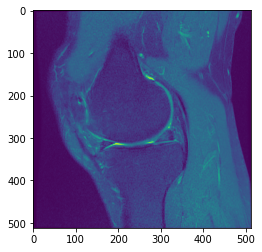

In [ ]:
pixel_data = dcm_df.get_pixel_data()
plt.imshow(pixel_data[:, :, 6])
plt.show()

### Loading single slice X-Ray

I2T2 can also load X-rays. A warning will tell us that `ImagePositionPatient` was not found but I2T2 will just ignore it since no slice sorting is needed.

ImagePositionPatient  tag was not found! Skipping... (0020, 0032)


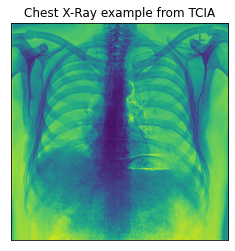

In [ ]:
chest_xray_path = os.path.join(DATA_ROOT,'chest-xray')

dcm_df = dicom_dataframe(path_to_dicom_dir=chest_xray_path, dicom_extension='dcm')
pixel_data = dcm_df.get_pixel_data()
plt.title('Chest X-Ray example from TCIA')
plt.imshow(pixel_data[:,:,0])
plt.yticks([])
plt.xticks([])
plt.show()

### Tests

In [ ]:
#test if Xray is loading correctly
dcm_df = dicom_dataframe(path_to_dicom_dir=chest_xray_path, dicom_extension='dcm')
pixel_data = dcm_df.get_pixel_data()
assert(pixel_data.shape == (2022, 2022, 1))

ImagePositionPatient  tag was not found! Skipping... (0020, 0032)


In [ ]:
#test 
#make sure dataframe is ordered correctly
data_path = os.path.join(DATA_ROOT,'knee')
dcm_df = dicom_dataframe(path_to_dicom_dir=data_path, dicom_extension='dcm')
dcm_df.sort_dataframe_by_IPP_normal()
for i in range(len(dcm_df.dataframe) - 1):
    assert(dcm_df.dataframe['ImagePositionPatient_normal'].iloc[i+1] > dcm_df.dataframe['ImagePositionPatient_normal'].iloc[i])

In [ ]:
#test
np.testing.assert_equal(_get_normal_from_dicom_slice(dcm_df.dataframe['DS'].iloc[0]), np.array([-1., -0.,  0.]))

### Some handy dicom tests

In [ ]:
#export
import numpy as np
def get_plane(dcm):
    """
    Returns plane for input dicom
    Attributes:
        dcm (FileDataset): dicom slice, result from pydicom.dcmread()
    Returns:
        plane (str): axial or coronal or sagittal
    """
    if hasattr(dcm, 'ImageOrientationPatient'):
        IOP = _get_tag_from_loaded_dicom(dcm, 'ImageOrientationPatient')
        IOP_round = [round(x) for x in IOP]
        plane = np.cross(IOP_round[0:3], IOP_round[3:6])
        plane = [abs(x) for x in plane]
        if plane[0] == 1:
            return "sagittal"
        elif plane[1] == 1:
            return "coronal"
        elif plane[2] == 1:
            return "axial"
        else:
            return "Oblique acquisition (hope for the best)."
    else:
        raise KeyError('ImageOrientationPatient not in dicom')

def is_axial(dcm):
    return (get_plane(dcm) == "axial")

def is_sagittal(dcm):
    return (get_plane(dcm) == "sagittal")

def is_coronal(dcm):
    return (get_plane(dcm) == "coronal")

def is_fat_suppressed(dcm):
    if hasattr(dcm, 'ScanOptions'):
        return('FS' in _get_tag_from_loaded_dicom(dcm, 'ScanOptions'))
    else:
        raise KeyError('ScanOptions not in dicom')

In [ ]:
#tests
data_path = os.path.join(DATA_ROOT,'knee')
dcm_df = dicom_dataframe(path_to_dicom_dir=data_path, dicom_extension='dcm')

assert(is_fat_suppressed(dcm_df.dataframe['DS'].iloc[0]) == True)
assert(is_sagittal(dcm_df.dataframe['DS'].iloc[0]) == True)
assert(is_axial(dcm_df.dataframe['DS'].iloc[0]) == False)
assert(is_coronal(dcm_df.dataframe['DS'].iloc[0]) == False)

## Load .mat

In [ ]:
# export
def load_mat(path_to_mat_file=None, key='img'):
    """
    Loads matlab data as a numpy array.

    Attributes:
        path_to_mat_file (str): Path to mat file containing image / segmentation
        key (str): key to load from matlab dictionary

    Returns:
        pixel_array (arr): Array of pixel data
    """

    try:
        os.path.isfile(path_to_mat_file)

    except:
        print("mat file not found")

    else:
        pixel_array = spio.loadmat(path_to_mat_file)[key]

        return pixel_array
    return None

## Load .h5

In [ ]:
# export
def load_h5(path_to_h5_file=None):
    """
    Loads h5 files into numpy array.

    Attributes:
        path_to_h5_file (str): Path h5 file for one subject

    Returns:
        h5_file_dict (dict): Dictionary of pixel data
    """

    try:
        h5_file = h5py.File(path_to_h5_file, 'r')

    except:
        print("File", str(path_to_h5_file), "not found.")
        print("Make sure file exists")

    else:
        h5_file_dict = dict()
        keys = h5_file.keys()

        for k in keys:
            h5_file_dict[k] = h5_file.get(k)

        return(h5_file_dict)

### Usage

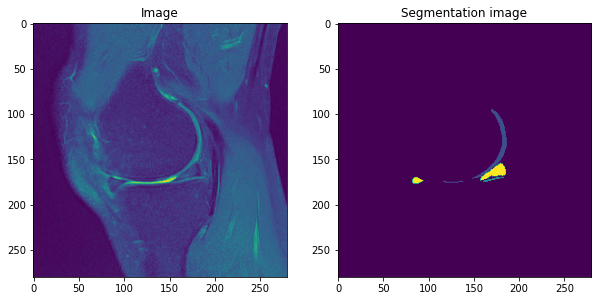

In [ ]:
segmentation_path = os.path.join(DATA_ROOT,'knee-segmentation','knee_segmentation.h5')

h5_file = load_h5(
    path_to_h5_file=segmentation_path)

# Plot
plt.figure(figsize=(10, 10))

plt.subplot(121)
plt.title('Image')
plt.imshow(h5_file['img'][:, :, 30])

plt.subplot(122)
plt.title('Segmentation image')
plt.imshow(h5_file['seg'][:, :, 30])

plt.show()